TODO:
- [x] threshold of [-1000,1000]  to make normalizing robust - and test on new data
- [ ] visualize FN and FP and attach number of clicks for these misclassifications
- [x] Compare with uniform distribution (because UD can better detect certain FN, like the plot with clicks all on one pixel) 
- [ ] maybe combine both with a certain weight to get a new representative bad heatmap
- [ ] bad data (H_0 banner is bad) vs uniform distribution (H_1 data is non-bad)


final output
- [ ] visualize FN and FP and attach number of clicks for these misclassifications

Functions: 
```{python}
all_preds = generate_all_preds(outputs, min, max)
plot_heatmaps(heatmap_list)
plot_roc_curve(all_labels, all_preds)
all_f1, best_f1, best_thresh = calculate_all_f1(all_labels, all_preds)
all_outputs = combine_all_outputs(output_list)
fn, fp = identify_misclassified_banners(domains, preds, labels, thresh)
```

# 1. Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

In [2]:
data_heatmap = pd.read_csv('../datasets/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_3p.csv')
data_heatmap_new1 = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_h2m.csv')
data_heatmap_new2 = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_t2m.csv')

In [3]:
data_metrics_6p = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_6p.csv')

In [4]:
data_heatmap_6p = pd.concat([data_heatmap_new1,data_heatmap_new2],axis=0).drop(columns=['click_x_rel','click_y_rel'])

In [5]:
# importing broken banners
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

cb_333346_6p = ['ID_106', 'ID_1108', 'ID_1111', 'ID_1150', 'ID_1217', 'ID_136', 
             'ID_1542', 'ID_1589', 'ID_1602', 'ID_185', 'ID_1908', 'ID_1915', 
             'ID_1916', 'ID_1971',  'ID_2015', 'ID_2063', 'ID_2133', 'ID_2143', 
             'ID_2336', 'ID_2337', 'ID_2368', 'ID_243', 'ID_245', 'ID_2553', 
             'ID_2564', 'ID_2635', 'ID_2636', 'ID_267', 'ID_2693', 'ID_27', 
             'ID_2737', 'ID_2750', 'ID_2762', 'ID_2867', 'ID_2924', 'ID_2933', 
             'ID_2977', 'ID_3172', 'ID_3219', 'ID_324', 'ID_3268', 'ID_333', 
             'ID_3334', 'ID_3487', 'ID_3526', 'ID_3535', 'ID_3567', 'ID_3605', 
             'ID_362', 'ID_3633', 'ID_3640', 'ID_365', 'ID_367', 'ID_3672', 
             'ID_3699', 'ID_3730', 'ID_3809', 'ID_3837', 'ID_3848', 'ID_3920', 
             'ID_3939', 'ID_3982', 'ID_401', 'ID_4042', 'ID_4058', 'ID_4072', 
             'ID_4076', 'ID_4199', 'ID_4206', 'ID_4224', 'ID_4378', 'ID_4507', 
             'ID_466', 'ID_494', 'ID_539', 'ID_62', 'ID_727', 'ID_737', 
             'ID_861', 'ID_876', 'ID_889', 'ID_90', 'ID_922', 'ID_949', 
             'ID_981', 'ID_993']

cb_333519_6p = ['ID_1081', 'ID_1150', 'ID_1464', 'ID_1518', 'ID_1622', 'ID_1623', 
                'ID_1624', 'ID_1631', 'ID_1678', 'ID_1623', 'ID_1731', 'ID_1752', 
                'ID_1764', 'ID_1795', 'ID_1915', 'ID_1916', 'ID_1971', 'ID_198', 
                'ID_2018', 'ID_204', 'ID_2044', 'ID_2104', 'ID_2108', 'ID_2109', 
                'ID_2146', 'ID_2251', 'ID_2330', 'ID_2336', 'ID_2381', 'ID_2383', 
                'ID_2400', 'ID_2616', 'ID_2636', 'ID_2749', 'ID_2766', 'ID_2779', 
                'ID_2809', 'ID_284', 'ID_2875', 'ID_2881', 'ID_30', 'ID_3021', 
                'ID_3049', 'ID_3098', 'ID_3178', 'ID_3183', 'ID_3219', 'ID_3232', 
                'ID_3561', 'ID_3644', 'ID_365', 'ID_3850', 'ID_389', 'ID_4025', 
                'ID_4036', 'ID_4050', 'ID_4058', 'ID_4075', 'ID_4113', 'ID_4122', 
                'ID_4255', 'ID_4257', 'ID_4275', 'ID_4347', 'ID_44', 'ID_4506', 
                'ID_4567', 'ID_618', 'ID_727', 'ID_737', 'ID_922', 'ID_950', 
                'ID_960', 'ID_969']

cb_333346_6p = ['ID_106', 'ID_1003', 'ID_1081', 'ID_1108', 'ID_1111', 'ID_1150', 'ID_1217', 'ID_1303', 'ID_1347', 
                'ID_136', 'ID_1464', 'ID_1542', 'ID_1579', 'ID_1589', 'ID_1602', 'ID_1624','ID_1640', 'ID_1731',
                'ID_185', 'ID_1902', 'ID_1908', 'ID_1915', 'ID_1916', 'ID_1917','ID_1971', 'ID_1974', 'ID_2015', 
                'ID_2063', 'ID_2077', 'ID_2099', 'ID_2104', 'ID_2108', 'ID_2133', 'ID_2143', 'ID_2214', 'ID_2242',
                'ID_2279', 'ID_2336', 'ID_2337', 'ID_2368', 'ID_2400', 'ID_2404', 'ID_243', 'ID_2435', 'ID_245', 
                'ID_2553', 'ID_2564', 'ID_2598', 'ID_2626', 'ID_2627', 'ID_2635', 'ID_2636', 'ID_2648', 'ID_267', 
                'ID_2693', 'ID_27', 'ID_2737', 'ID_2750', 'ID_2760', 'ID_2762', 'ID_2766', 'ID_2779', 'ID_2809', 
                'ID_2867', 'ID_2881', 'ID_2924', 'ID_2933', 'ID_2977', 'ID_3019', 'ID_3098', 'ID_313', 'ID_3157', 
                'ID_3172', 'ID_3178', 'ID_3219', 'ID_3231', 'ID_324', 'ID_3268', 'ID_3308', 'ID_333', 'ID_3334', 
                'ID_3375', 'ID_3389', 'ID_3405', 'ID_3418', 'ID_3472', 'ID_3487', 'ID_3526', 'ID_3535', 'ID_3567',
                'ID_3605', 'ID_3614', 'ID_362', 'ID_3633', 'ID_3640', 'ID_3644', 'ID_365', 'ID_367', 'ID_3672', 
                'ID_3699', 'ID_3726', 'ID_3730', 'ID_3781', 'ID_3799', 'ID_3800', 'ID_3809', 'ID_3837', 'ID_3848', 
                'ID_3850', 'ID_389', 'ID_3917', 'ID_3920', 'ID_3939', 'ID_3982', 'ID_401', 'ID_4016', 'ID_4040',
                'ID_4042', 'ID_4058', 'ID_4072', 'ID_4076', 'ID_4199', 'ID_4204', 'ID_4206', 'ID_4224', 'ID_4275',
                'ID_429', 'ID_4347', 'ID_4378', 'ID_4507', 'ID_4567','ID_466', 'ID_494', 'ID_514', 'ID_539', 
                'ID_582', 'ID_62', 'ID_71', 'ID_727', 'ID_731', 'ID_737', 'ID_825', 'ID_861', 'ID_869', 'ID_876', 
                'ID_889', 'ID_90', 'ID_922', 'ID_949', 'ID_969', 'ID_979', 'ID_981', 'ID_993']

cb_333346_new = ['ID_1071', 'ID_1149', 'ID_1246', 'ID_1300', 'ID_1358', 'ID_1614', 'ID_1894', 'ID_1999', 
                 'ID_2142', 'ID_2198', 'ID_2274', 'ID_2331', 'ID_2400', 'ID_2438', 'ID_2495', 'ID_2710', 
                 'ID_2808', 'ID_3197', 'ID_3335', 'ID_418', 'ID_657', 'ID_773', 'ID_906', 'ID_962']

cb_333519_new = ['ID_10', 'ID_1077', 'ID_1178', 'ID_1203', 'ID_1246', 'ID_1262', 'ID_1671', 'ID_1691', 
                 'ID_1999', 'ID_2198', 'ID_2495', 'ID_2569', 'ID_2619', 'ID_3180', 'ID_3308', 'ID_394', 
                 'ID_678', 'ID_793']


In [6]:
cb = {333519: cb_333519+cb_333519_new, 333346: cb_333346+cb_333346_new}
cb_6p = {333519: cb_333519_6p, 333346: cb_333346_6p}

# cb = {333519: cb_333519, 333346: cb_333346}
# cb_333346 = cb_333346+['ID_2274','ID_2198','ID_962', 'ID_657']

# 2. Some Data wrangling

In [7]:
data_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)

max_width = data_expanded['display_width'].max()
max_height = data_expanded['display_height'].max()

width_bins = np.linspace(1, max_width, 61)
height_bins = np.linspace(1, max_height, 51)

data_expanded['click_x_bin'] = pd.cut(data_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_expanded['click_y_bin'] = pd.cut(data_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')

# cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
# cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
# cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()

aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

In [8]:
data_expanded_6p = data_heatmap_6p.loc[data_heatmap_6p.index.repeat(data_heatmap_6p['clicks'])].reset_index(drop=True)

max_width = data_expanded_6p['display_width'].max()
max_height = data_expanded_6p['display_height'].max()

width_bins = np.linspace(1, max_width, 61)
height_bins = np.linspace(1, max_height, 51)

data_expanded_6p['click_x_bin'] = pd.cut(data_expanded_6p['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_expanded_6p['click_y_bin'] = pd.cut(data_expanded_6p['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks_6p = data_expanded_6p.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


aggregated_clicks_by_grid_6p = aggregated_clicks_6p.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

Calculate the empirical distribution for the working banners (i.e. $H_0$). To do this, we pick a representative banner from the same dataset. This is hence a one shot learning algorithm

In [9]:
# save domains by grid id:
domains_by_grid_id = pd.DataFrame(aggregated_clicks.groupby('grid_id')['domain'].unique()).reset_index()
domains_by_grid_id_6p = pd.DataFrame(aggregated_clicks_6p.groupby('grid_id')['domain'].unique()).reset_index()

In [10]:
def generate_preds(outputs, min, max):
    # all_outputs = np.array(outputs[333346] + outputs[333519])
    print(min)
    print(max)
    preds = {}
    for g_id in [333346, 333519]:
        preds_g_id = np.negative(np.array(outputs[g_id]))
        preds_g_id = (np.array(outputs[g_id]) - max)/(min - max)
        preds_g_id = [1 if preds_g_id[i] > 1 else preds_g_id[i] for i in range(len(preds_g_id))]
        preds_g_id = [0 if preds_g_id[i] < 0 else preds_g_id[i] for i in range(len(preds_g_id))]
        preds[g_id] = preds_g_id
    return preds

In [11]:
def combine_all_outputs(output_list):
    return np.array(output_list[333346] + output_list[333519])

In [12]:
def plot_heatmaps(heatmap_list, g_id):
    for dom in heatmap_list:
        data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                    (aggregated_clicks.domain == dom)]
        print(f'Total clicks for (grid_id, domain): ({g_id}, {dom}): {data_obs.clicks_sum.sum()}')
        # data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
        # data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
        click_matrix = data_obs.pivot("click_y_bin",
                                        "click_x_bin",
                                        "clicks_sum").fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(click_matrix, 
                    cmap = "YlGnBu", 
                    annot = False, 
                    cbar = True, 
                    fmt = "g")
        plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
        plt.xlabel('click_x Bin')
        plt.ylabel('click_y Bin')
        plt.gca().invert_yaxis() 
        plt.show()

In [13]:
def plot_heatmap_from_distribution(heatmap):
    click_matrix = heatmap.pivot("click_y_bin",
                                    "click_x_bin",
                                    "proba").fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'Click Heatmap')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

In [14]:
def plot_roc_curve(all_labels, all_preds):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

    # Calculate AUC score
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return auc

In [21]:
def calculate_all_f1(all_labels, all_preds):
    threshs = np.linspace(1,0.01,100)
    best_f1 = 0
    best_thresh = 0
    all_f1 = []
    for thresh in threshs:
        all_preds_cut_off = [1 if all_preds[i] > thresh else 0 for i in range(len(all_preds))]
        f1 = f1_score(all_labels, all_preds_cut_off, average='binary')
        
        if best_f1 < f1:
            best_f1 = f1
            best_thresh = thresh
        all_f1.append(f1)
        # print(f1)
    return all_f1, best_f1, best_thresh

In [16]:
def identify_misclassified_banners(domains, preds, labels, thresh):
    fn = {}
    fp = {}
    # for each g_id
    for g_id in [333346, 333519]:
        fn_g_id = []
        fp_g_id = []
        domains_g_id = domains[g_id]
        # round preds to 0 and 1 for g_id
        preds_rounded = [0 if preds[g_id][i] < thresh else 1 for i in range(len(preds[g_id]))] 
        # for each banner
        for ind in range(len(domains[g_id])):
            if preds_rounded[ind] == 0 and labels[g_id][ind] == 1: # False negative
                fn_g_id.append(domains_g_id[ind])
            elif preds_rounded[ind] == 1 and labels[g_id][ind] == 0: # False positive
                fp_g_id.append(domains_g_id[ind])
        fn[g_id] = fn_g_id
        fp[g_id] = fp_g_id
    return fn, fp

In [17]:
def plot_false_heatmaps(aggregated_clicks, heatmap_dict_by_gid, dataset, which_false, notebook_name):
    for g_id in [333346, 333519]:
        nb_clicks_per_heatmap = []
        heatmap_list = heatmap_dict_by_gid[g_id]
        for dom in heatmap_list:
            data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                        (aggregated_clicks.domain == dom)]
            print(f'Total clicks for (grid_id, domain): ({g_id}, {dom}): {data_obs.clicks_sum.sum()}')
            nb_clicks_per_heatmap.append((dom,data_obs.clicks_sum.sum()))
            # data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
            # data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
            click_matrix = data_obs.pivot("click_y_bin",
                                            "click_x_bin",
                                            "clicks_sum").fillna(0)
            plt.figure(figsize=(8, 6))
            sns.heatmap(click_matrix, 
                        cmap = "YlGnBu", 
                        annot = False, 
                        cbar = True, 
                        fmt = "g")
            plt.title(f'Click Heatmap for id = {dom} and grid = {g_id}, nb clicks = {data_obs.clicks_sum.sum()}')
            plt.xlabel('click_x Bin')
            plt.ylabel('click_y Bin')
            plt.gca().invert_yaxis() 
            # plt.show()
            plt.savefig(f'Stat_approach_output/{notebook_name}/{dataset}/{which_false}/{g_id}/{dom}.jpg')
        heatmap_dict_by_gid[g_id] = nb_clicks_per_heatmap
    return heatmap_dict_by_gid

# Actual work begins here

In [34]:
import pickle
with open('Stat_approach_output/test_4.pkl', 'rb') as f:
    check_results = pickle.load(f)

In [35]:
time_per_banner_old = check_results['old']['time_per_banner']
outputs_old = check_results['old']['outputs'] # LRT outputs
labels_old = check_results['old']['labels']
domains_old = check_results['old']['domains']

In [36]:
time_per_banner_new = check_results['new']['time_per_banner']
outputs_new = check_results['new']['outputs']
labels_new = check_results['new']['labels']
domains_new = check_results['new']['domains']

-3981.5928529666853
1433.5172930571907


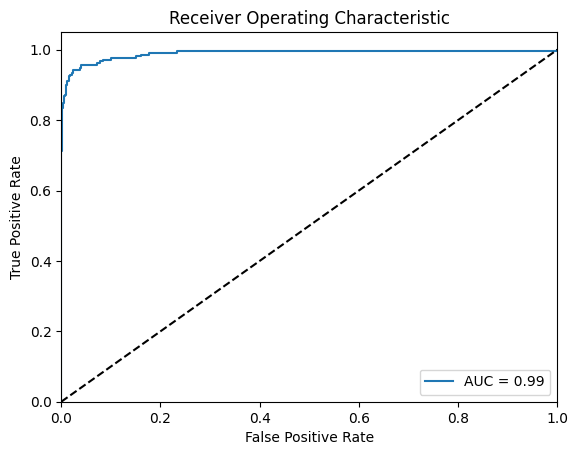

Time per banner:  0.059601034515521734
Best f1 is 0.91 at threshold 0.27
Confusion matrix at best threshold: 
[[1507   14]
 [  22  190]]
AUC:  0.9884137794152308


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

preds_old = generate_preds(outputs_old, min(outputs_old[333346] + outputs_old[333519]), max(outputs_old[333346] + outputs_old[333519]))
all_labels_old = combine_all_outputs(labels_old)
all_preds_old = combine_all_outputs(preds_old)
all_outputs_old = combine_all_outputs(outputs_old)
all_f1_old, best_f1_old, best_thresh_old = calculate_all_f1(all_labels_old, all_preds_old)
all_preds_rounded_old = [1 if all_preds_old[i] > best_thresh_old else 0 for i in range(len(all_preds_old))]
fn_old, fp_old = identify_misclassified_banners(domains_old, preds_old, labels_old, best_thresh_old)
auc_old = plot_roc_curve(all_labels_old, all_preds_old)

print("Time per banner: ", time_per_banner_old) # time per domain
print(f"Best f1 is {round(best_f1_old, 2)} at threshold {round(best_thresh_old, 2)}")
print("Confusion matrix at best threshold: ")
print(confusion_matrix(all_labels_old, all_preds_rounded_old)) # true (rows), predicted (columns) 
print("AUC: ", auc_old)

-6014.806533648776
1076.6029136375191


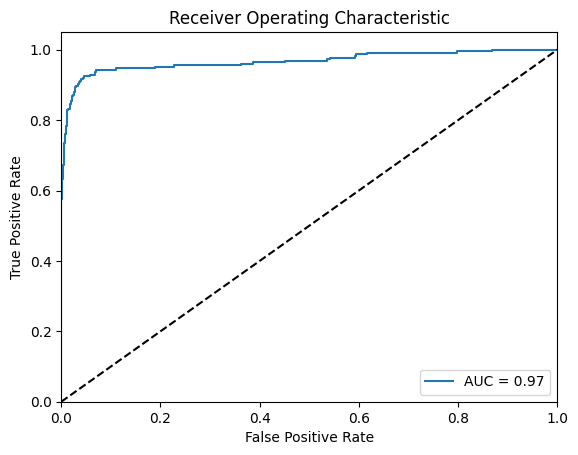

Time per banner:  0.1022636613436658
Best f1 is 0.83 at threshold 0.17
Confusion matrix at best threshold: 
[[2768   36]
 [  39  187]]
AUC:  0.9668820143158321


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

preds_new = generate_preds(outputs_new, min(outputs_new[333346] + outputs_new[333519]), max(outputs_new[333346] + outputs_new[333519]))
all_labels_new = combine_all_outputs(labels_new)
all_preds_new = combine_all_outputs(preds_new)
all_outputs_new = combine_all_outputs(outputs_new)
all_f1_new, best_f1_new, best_thresh_new = calculate_all_f1(all_labels_new, all_preds_new)
all_preds_rounded_new = [1 if all_preds_new[i] > best_thresh_new else 0 for i in range(len(all_preds_new))]
fn_new, fp_new = identify_misclassified_banners(domains_new, preds_new, labels_new, best_thresh_new)
auc_new = plot_roc_curve(all_labels_new, all_preds_new)

print("Time per banner: ", time_per_banner_new) # time per domain
print(f"Best f1 is {round(best_f1_new, 2)} at threshold {round(best_thresh_new, 2)}")
print("Confusion matrix at best threshold: ")
print(confusion_matrix(all_labels_new, all_preds_rounded_new)) # true (rows), predicted (columns) 
print("AUC: ", auc_new)

In [43]:
best_thresh_old

0.22999999999999998

In [44]:
best_thresh_new

0.25

In [47]:
all_preds_binary_old = np.where(all_preds_old >= best_thresh_new, 1, 0)
f1_score(all_labels_old, all_preds_binary_old)

0.8415584415584415

In [48]:
all_preds_binary_new = np.where(all_preds_new >= best_thresh_old, 1, 0)
# confusion_matrix(all_labels_new, all_preds_binary_new)
f1_score(all_labels_new, all_preds_binary_new)


0.7889908256880733

In [31]:
# def plot_roc_curve(all_labels, all_preds):
#     # Calculate ROC curve
#     fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

#     # Calculate AUC score
#     auc = roc_auc_score(all_labels, all_preds)

#     # Plot ROC curve
#     plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
#     plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic')
#     plt.legend(loc="lower right")
#     plt.show()
#     return auc